In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

# Loading data

In [2]:
tt_train =  pd.read_csv("train.csv")
tt_test =  pd.read_csv("test.csv")
tt = tt_train.append(tt_test, ignore_index = True, sort = True)
tt.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [3]:
tt.info()
tt.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000,0.000000
75%,39.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000


* Age: 263 missing values 

* Cabin: 1014 missing values 

* Embarked: 2 missing values
* Fare: 1 missing values

# Preprocessing

In [4]:
# def predictAge(tt):
#     num_tt = tt[['Age','Fare', 'Parch', 'SibSp', 'Pclass']]
#     haveAge = num_tt.loc[num_tt['Age'].notnull(),:].copy()
#     dontHaveAge = num_tt.loc[num_tt['Age'].isnull(),:].copy()
#     y = haveAge.iloc[:, 0]
#     X = haveAge.iloc[:, 1:]
#     rfr = RandomForestRegressor(random_state=1, n_estimators=2000, n_jobs=-1)
#     rfr.fit(X, y)
#     y_pred = rfr.predict(dontHaveAge.iloc[:, 1:])
#     tt.loc[tt['Age'].isnull(), 'Age' ] = y_pred 
#     tt = tt
#     return tt, rfr

# Handling missing value

In [5]:
tt['Fare'] = tt['Fare'].fillna(tt['Fare'].mean())
tt['Embarked'] = tt['Embarked'].fillna(tt['Embarked'].mode()[0])
tt['Cabin'] = tt['Cabin'].fillna('U') # U: unknown
# tt, rfr = predictAge(tt) # Filling missing value Age by random forest regressor

# Etract new features

In [6]:
tt['Deck'] = tt['Cabin'].apply(lambda x:x[0]) # Extract Deck by the first letter of Cabin
tt['DeckKnown'] = tt['Deck'].apply(lambda x: 1 if x == 'U' else 0)

tt['Title'] = tt['Name'].str.extract('([A-Za-z]+)\.', expand=False) # Split name and extract titles as title group function

## Impute Age by filling the median age of same title people. RF model didn't perform a better in predicting age
medianAge = tt.groupby('Title')['Age'].median()
ageDict = medianAge.to_dict()
titles = medianAge.index.tolist()
for title in titles:
    fillAge = medianAge[title]
    tt.loc[(tt['Age'].isnull()) & (tt['Title'] == title), 'Age'] = fillAge

title = (tt['Title'].value_counts() < 10) # Set titles whose count is lower than 10 as "Rare"
tt['Title'] = tt['Title'].apply(lambda x: 'Rare' if title.loc[x] == True else x)

tt['FamilySize'] = tt['SibSp'] + tt['Parch'] + 1 # Summary the number of family members for each people
tt['FamilySize'] = tt['FamilySize'].apply(lambda x: 'Single' if x == 1 else ('Normal' if 1<x<4 else 'Large')) # Category family size by 1, 1-3, over 3

tt["AgeGroup"]=pd.cut(tt["Age"],range(0,90,15)) # Category Age by groups, especially for child group with age lower than 12

tt['FareGroup'] = pd.qcut(tt['Fare'], 4) # Category Fare by quantile groups

# tt.loc[tt['Age']<=16, 'Person'] ='child' # Category Age_Sex by child, man and woman
# tt.loc[(tt['Age']>16) & (tt['Sex']=='female'), 'Person'] = 'adult_woman'
# tt.loc[(tt['Age']>16) & (tt['Sex']=='male'), 'Person'] = 'adult_man'

# Marked people with same surname
# Since people in the same family tend to survive or die together
tt['Surname'] = tt['Name'].apply(lambda x : x.split(',')[1].split('.')[1].strip())
countMap= tt['Surname'].value_counts().to_dict()
tt['Surname'] = tt['Surname'].map(countMap)
tt.loc[tt['Surname'] > 1,'alone_NoSameSurname_members'] = 1
tt.loc[tt['Surname'] == 1,'alone_NoSameSurname_members'] = 0 # alone

# Marked people who has same ticket as ShareTicket condition
# Since people who have same ticket knowing each others (friends, family and other relationships) tend to survive or die together
ticketMap = tt['Ticket'].value_counts().to_dict()
tt['TicketCount'] = tt['Ticket'].map(ticketMap)
tt.loc[tt['TicketCount'] > 1,'ShareTicket'] = 1
tt.loc[tt['TicketCount'] == 1,'ShareTicket'] = 0

# Visualization: Relastions between features and survival

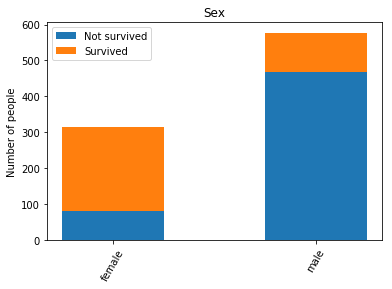

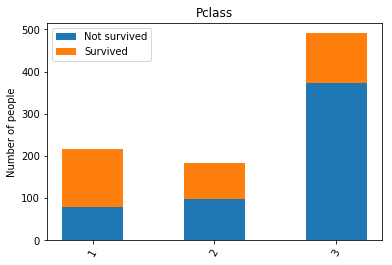

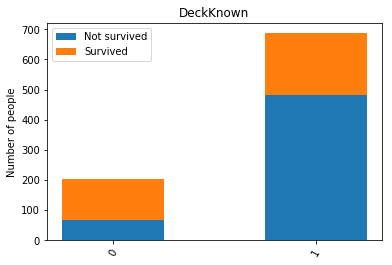

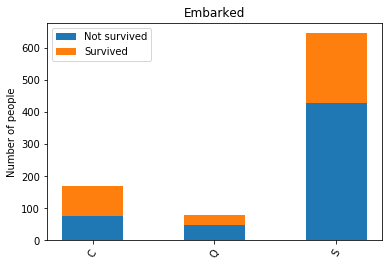

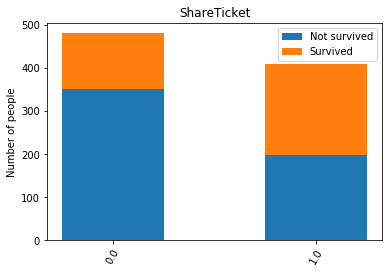

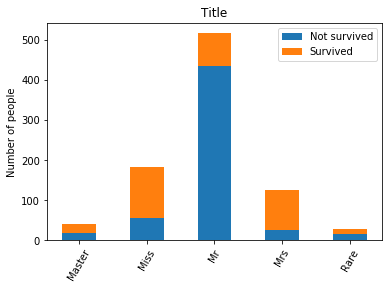

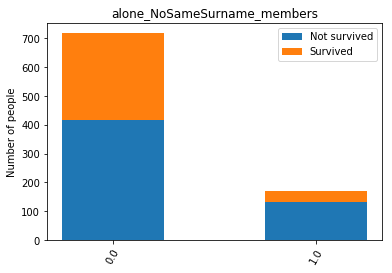

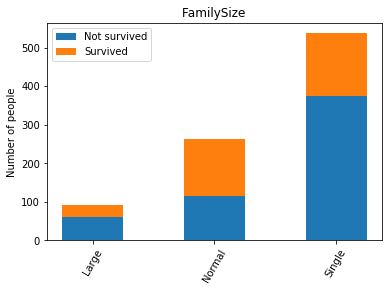

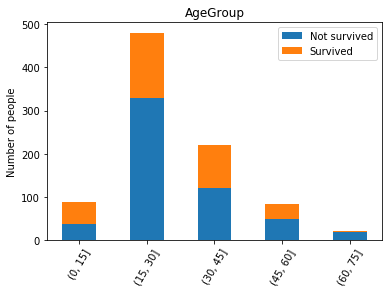

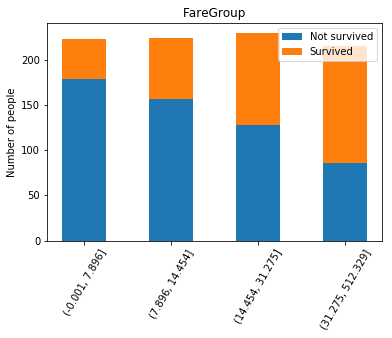

In [7]:
features = ["Sex","Pclass","DeckKnown","Embarked","ShareTicket","Title","alone_NoSameSurname_members","FamilySize","AgeGroup","FareGroup"]

pltDict={}
for f in features:
    temp=tt.groupby(["Survived",f]).size()
    pltDict[f]=pd.concat([temp[0],temp[1]],axis=1,sort=False).fillna(0)

for f in features:
    N = len(pltDict[f][0])
    ind = np.arange(N)    # the x locations for the groups
    width = 0.5       # the width of the bars: can also be len(x) sequence
    survived_num = pltDict[f][1]
    not_survived_num = pltDict[f][0]

    plt.bar(ind, not_survived_num, width, label="Not survived")
    plt.bar(ind, survived_num, width, bottom = not_survived_num, label = "Survived")
    plt.xticks(ind, pltDict[f].index.values, rotation = 60)
    plt.ylabel("Number of people")
    plt.title(f)
    plt.legend()
    plt.show()

# One-hot encoding for categorical variable

In [8]:
dummies_Embarked = pd.get_dummies(tt['Embarked'], prefix= 'Embarked')
dummies_Sex = pd.get_dummies(tt['Sex'], prefix= 'Sex')
dummies_Title = pd.get_dummies(tt['Title'], prefix= 'Title')
# dummies_Person = pd.get_dummies(tt['Person'], prefix= 'Person')
dummies_FamilySize = pd.get_dummies(tt['FamilySize'], prefix= 'FamilySize')
dummies_AgeGroup = pd.get_dummies(tt['AgeGroup'], prefix= 'AgeGroup')
dummies_FareGroup = pd.get_dummies(tt['FareGroup'], prefix= 'FareGroup')

PassengerId = tt.loc[891:,'PassengerId']
tt = tt.drop(['Name','PassengerId','Surname','Age','Fare','Ticket','Cabin','Embarked','Sex','FareGroup','AgeGroup','SibSp','Parch','TicketCount','Deck','FamilySize','Title'],axis=1)

In [9]:
tt = pd.concat([tt, dummies_AgeGroup, dummies_FareGroup, dummies_Embarked, dummies_Sex, dummies_Title, dummies_FamilySize],axis=1)
tt.head()

,Pclass,Survived,DeckKnown,alone_NoSameSurname_members,ShareTicket,"AgeGroup_(0, 15]","AgeGroup_(15, 30]","AgeGroup_(30, 45]","AgeGroup_(45, 60]","AgeGroup_(60, 75]",...,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,FamilySize_Large,FamilySize_Normal,FamilySize_Single
0,3,0.0,1,0.0,0.0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,1,0
1,1,1.0,0,0.0,1.0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,1,0
2,3,1.0,1,0.0,0.0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,1
3,1,1.0,0,0.0,1.0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,1,0
4,3,0.0,1,1.0,0.0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,1


# Base Modeling & Evaluation

In [10]:
# Drop Survived to split series easily 
survived = tt['Survived']
tt = tt.drop(['Survived'], axis = 1)
# Normalization
tt = tt.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x))) 
tt['Survived'] = survived

In [11]:
# Split X_train, X_test, y_train
x_train = tt.iloc[0:891, :-1]
y_train = tt.iloc[0:891, -1]
x_test = tt.iloc[891: , :-1]

## Model comparison: Logistic Regression, SVM, Naive Bayes, Decision Tree, Random Forest

In [12]:
# # Logistic Regression
# lg = LogisticRegression()
# lg.fit(x_train, y_train.values.ravel())
# y_pred = lg.predict(x_test)
# lg = lg.score(x_train, y_train)

# # Support Vector Machines
# svc = SVC(gamma = 'auto')
# svc.fit(x_train, y_train.values.ravel())
# y_pred = svc.predict(x_test)
# svc = svc.score(x_train, y_train)

# # Gaussian Naive Bayes
# gaussian = GaussianNB()
# gaussian.fit(x_train, y_train.values.ravel())
# y_pred = gaussian.predict(x_test)
# gaussian = gaussian.score(x_train, y_train)

# # Decision Tree
# decision_tree = DecisionTreeClassifier()
# decision_tree.fit(x_train, y_train.values.ravel())
# y_pred = decision_tree.predict(x_test)
# dt = decision_tree.score(x_train, y_train)

# # Random Forest
# random_forest = RandomForestClassifier(n_estimators=100)
# random_forest.fit(x_train, y_train.values.ravel())
# y_sub = random_forest.predict(x_test)
# rf = random_forest.score(x_train, y_train)

# # Model comparison
# models = pd.DataFrame({
#     'Model': ['Support Vector Machines', 'Logistic Regression', 'Random Forest', 'Naive Bayes', 'Decision Tree'],
#     'Score': [svc, lg, rf, gaussian, dt]})
# models.sort_values(by='Score', ascending=False)

In [13]:
# svc = SVC() # rbf kernel
# parameter_grid = {
#                  'C': [0.001,0.01,0.1,1,10],
#                  'gamma': [0.1,0.01,0.001],
#                  }
# cross_validation = StratifiedKFold(n_splits=5)
# grid_search = GridSearchCV(svc,
#                            param_grid=parameter_grid,
#                            cv=cross_validation,
#                            iid=True)
# grid_search.fit(x_train, y_train)
# print('Best score: {}'.format(grid_search.best_score_))
# print('Best parameters: {}'.format(grid_search.best_params_))

In [14]:
# rf = RandomForestClassifier(max_features='sqrt')
# parameter_grid = {
#                  'max_depth' : [4,5,6,7,8],
#                  'n_estimators': [100,150,200,250,400],
#                  'criterion': ['gini','entropy'],
#                  }
# cross_validation = StratifiedKFold(n_splits=5)
# grid_search = GridSearchCV(rf,
#                            param_grid=parameter_grid,
#                            cv=cross_validation,
#                            iid=True)
# grid_search.fit(x_train, y_train)
# print('Best score: {}'.format(grid_search.best_score_))
# print('Best parameters: {}'.format(grid_search.best_params_))

In [15]:
# gbdt = GradientBoostingClassifier(n_estimators=200, learning_rate = 0.1)
# parameter_grid = {
#                  'n_estimators': [100,150,200,300],
#                  'learning_rate': [0.01, 0.1, 1],
#                  'subsample': [0.6, 0.7, 0.8],
#                  'max_depth' : [4,5,6,7,8],
#                  }
# cross_validation = StratifiedKFold(n_splits=5)
# grid_search = GridSearchCV(gbdt,
#                            param_grid=parameter_grid,
#                            cv=cross_validation,
#                            iid=True)
# grid_search.fit(x_train, y_train)
# print('Best score: {}'.format(grid_search.best_score_))
# print('Best parameters: {}'.format(grid_search.best_params_))

# # Best score: 0.8372615039281706
# # Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.6}

In [16]:
rf = RandomForestClassifier(n_estimators=150, max_depth=7, criterion='gini')
rf.fit(x_train, y_train)
y_sub = rf.predict(x_test)

# Ensemble GBDT by voting make model worse! should ensemble other models in other ways(bagging/boosting/voting)

# gbdt = GradientBoostingClassifier(n_estimators=300, learning_rate=0.01, subsample=0.6, max_depth=5)
# voting = VotingClassifier(estimators=[('rf', rf), ('gbdt', gbdt)], voting='soft')
# voting.fit(x_train, y_train)
# y_sub = voting.predict(x_test)

In [17]:
# Submission
# submission = pd.DataFrame({
#         "PassengerId": PassengerId,
#         "Survived": y_sub.astype(int)
#     })
# submission.to_csv('submission.csv', index=False)